In [1]:
import os
from dotenv import load_dotenv
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.schema import Document
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever, MultiQueryRetriever, ContextualCompressionRetriever, EnsembleRetriever, SelfQueryRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor, EmbeddingsFilter, DocumentCompressorPipeline
from langchain_openai.chat_models import ChatOpenAI
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline, EmbeddingsFilter
from pydantic import BaseModel, Field
from langchain.chains import LLMChain
from typing import List
import faiss
from datetime import datetime, timedelta
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain.retrievers import TimeWeightedVectorStoreRetriever
from langchain.vectorstores import FAISS
from langchain.retrievers import BM25Retriever
import time
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.load import dumps, loads
from operator import itemgetter

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

class ParentDocumentRetrieverClass:
    def __init__(self, docs):
        self.docs = docs
        self.embedding = OpenAIEmbeddings()
        self.childSplitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=30)
        self.ParentSplitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=60)
        self.vectorstore = Chroma(collection_name="Project_documents", embedding_function=self.embedding)
        self.store = InMemoryStore()
        self.retriever = ParentDocumentRetriever(vectorstore=self.vectorstore, splitter=self.ParentSplitter, docstore=self.store, child_splitter=self.childSplitter, parent_splitter=self.ParentSplitter)
        self.retriever.add_documents(self.docs, ids=None)
        self.llm = ChatOpenAI(
            temperature=0,
            model_name="gpt-4-turbo-preview",
            openai_api_key=os.getenv("OPENAI_API_KEY"),
            max_tokens=800,
            model_kwargs={
                "top_p": 0,
                "frequency_penalty": 0,
                "presence_penalty": 0
            },
        )
        self.qa = RetrievalQA.from_chain_type(llm=self.llm, chain_type="stuff", retriever=self.retriever)

    def get_response(self, query):
        result_from_retriever = self.qa.invoke(query)
        return result_from_retriever['result']
    
def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

class MultiQueryRetrieverClass:
    def __init__(self, docs):
        self.docs = docs
        self.embedding = OpenAIEmbeddings()
        self.splitters = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=30)
        self.splits = self.splitters.split_documents(self.docs)
        self.vectorstore = Chroma.from_documents(documents=self.splits, embedding=self.embedding)
        self.retriever = self.vectorstore.as_retriever()
        self.llm = ChatOpenAI(
            temperature=0,
            model_name="gpt-4-turbo-preview",
            openai_api_key=os.getenv("OPENAI_API_KEY"),
            max_tokens=800,
            model_kwargs={
                "top_p": 0,
                "frequency_penalty": 0,
                "presence_penalty": 0
            },
        )
        self.multi_query_retriever_template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
        self.prompt_perspectives = ChatPromptTemplate.from_template(self.multi_query_retriever_template)
        self.generate_queries = (
            self.prompt_perspectives
            | self.llm
            | StrOutputParser()
            | (lambda x: x.split("\n"))
        )


        self.retrieval_chain = self.generate_queries | self.retriever.map() | get_unique_union
        self.final_rag_multi_query_template = """Answer the following question based on this context:

{context}

Question: {question}
"""
        self.prompt = ChatPromptTemplate.from_template(self.final_rag_multi_query_template)
        self.final_rag_chain = (
            {"context": self.retrieval_chain, "question": itemgetter("question")}
            | self.prompt
            | self.llm
            | StrOutputParser()
        )

    def get_response(self, query):
        result = self.final_rag_chain.invoke({"question": query})
        return result

class ContextualCompressionRetrieverClass:
    def __init__(self, docs):
        self.docs = docs
        self.embedding = OpenAIEmbeddings()
        self.splitters = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=30)
        self.splits = self.splitters.split_documents(self.docs)
        self.vectorstore = Chroma(collection_name="Project_Docs_Compression", embedding_function=self.embedding)
        self.vectorstore.add_documents(self.splits)
        self.retriever = self.vectorstore.as_retriever()
        self.splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
        self.redundant_filter = EmbeddingsRedundantFilter(embeddings=self.embedding)
        self.relevant_filter = EmbeddingsFilter(embeddings=self.embedding, similarity_threshold=0.76)
        self.pipeline_compressor = DocumentCompressorPipeline(transformers=[self.splitter, self.redundant_filter, self.relevant_filter])
        self.compression_retriever = ContextualCompressionRetriever(base_compressor=self.pipeline_compressor, base_retriever=self.retriever)
        self.llm = ChatOpenAI(
            temperature=0,
            model_name="gpt-4-turbo-preview",
            openai_api_key=os.getenv("OPENAI_API_KEY"),
            max_tokens=800,
            model_kwargs={
                "top_p": 0,
                "frequency_penalty": 0,
                "presence_penalty": 0
            },
        )
        self.qa_chain = RetrievalQA.from_chain_type(
            llm=self.llm,
            chain_type="stuff",
            retriever=self.compression_retriever,
            return_source_documents=True
        )

    def get_response(self, query):
        result = self.qa_chain({"query": query})
        return result['result']

class EnsembleRetrieverClass:
    def __init__(self, docs):
        self.docs = docs
        self.embedding = OpenAIEmbeddings()
        self.splitters = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=30)
        self.splits = self.splitters.split_documents(self.docs)
        self.vectorstore = Chroma.from_documents(documents=self.splits, embedding=self.embedding)
        self.bm25_retriever = BM25Retriever.from_documents(self.docs)
        self.bm25_retriever.k = 5
        self.chrome_vectorstore = Chroma.from_documents(self.docs, self.embedding)
        self.chrome_retriever = self.chrome_vectorstore.as_retriever()
        self.ensemble_retriever = EnsembleRetriever(
            retrievers=[self.bm25_retriever, self.chrome_retriever], weights=[0.5, 0.5]
        )
        self.llm = ChatOpenAI(
            temperature=0,
            model_name="gpt-4-turbo-preview",
            openai_api_key=os.getenv("OPENAI_API_KEY"),
            max_tokens=800,
            model_kwargs={
                "top_p": 0,
                "frequency_penalty": 0,
                "presence_penalty": 0
            },
        )
        self.qa = RetrievalQA.from_chain_type(llm=self.llm, chain_type="stuff", retriever=self.ensemble_retriever)

    def get_response(self, query):
        response = self.qa.invoke(query)
        return response['result']

class NormalLLMClass:
    def __init__(self):
        self.llm = ChatOpenAI(
            temperature=0,
            model_name="gpt-4-turbo-preview",
            openai_api_key=os.getenv("OPENAI_API_KEY"),
            max_tokens=800,
            model_kwargs={
                "top_p": 0,
                "frequency_penalty": 0,
                "presence_penalty": 0
            },
        )

    def get_response(self, query):
        prompt_template = PromptTemplate(input_variables=["query"], template="{query}")
        chain = LLMChain(llm=self.llm, prompt=prompt_template)
        result_llm = chain.invoke(query)
        return result_llm['text']

In [2]:
load_dotenv()

True

In [3]:
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
print(os.environ['OPENAI_API_KEY'])

sk-proj-51qiLhtA3eIDjQV3WtL0T3BlbkFJo8P9aPclqpZLMrybC21t


In [4]:
import json
import time
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

# Load test dataset
with open("test_dataset.jsonl", "r") as f:
    test_dataset = [json.loads(line) for line in f]

def calculate_exact_match(pred, true):
    return int(pred.strip() == true.strip())

def calculate_f1(pred, true):
    # Tokenize the predicted and true responses
    pred_tokens = pred.strip().split()
    true_tokens = true.strip().split()

    # Calculate true positives, false positives, and false negatives
    pred_counter = Counter(pred_tokens)
    true_counter = Counter(true_tokens)

    true_positives = sum((pred_counter & true_counter).values())
    false_positives = sum((pred_counter - true_counter).values())
    false_negatives = sum((true_counter - pred_counter).values())

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) else 0

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    return f1_score

def calculate_bleu(pred, true):
    reference = [true.split()]
    candidate = pred.split()
    score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    return score

def calculate_rouge(pred, true):
    rouge = Rouge()
    scores = rouge.get_scores(pred, true)
    return scores[0]  # Returns ROUGE-1, ROUGE-2, ROUGE-L scores

def measure_response_time(model, query):
    
    start_time = time.time()
    response = model.get_response(query)
    latency = time.time() - start_time
    return latency

In [5]:
# Load documents
loader = TextLoader("./dataset-creation-docs/outputs/databricks-dolly-15K.txt")
data3 = loader.load()
docs = data3

# Create instances of retriever classes
parent_retriever = ParentDocumentRetrieverClass(docs)
multi_query_retriever = MultiQueryRetrieverClass(docs)
compression_retriever = ContextualCompressionRetrieverClass(docs)
ensemble_retriever = EnsembleRetrieverClass(docs)
normal_llm = NormalLLMClass()

# Evaluate on test dataset
results = {}
models = ["parent_retriever", "multi_query_retriever", "compression_retriever", "ensemble_retriever", "normal_llm"]
for model in models:
    results[model] = {
        "ems": [],
        "f1s": [],
        "bleus": [],
        "rouges": [],
        "latencies": []
    }

for data_point in test_dataset:
    query = data_point["instruction"]
    true_response = data_point["response"]

    responses = {
        "parent_retriever": parent_retriever.get_response(query),
        "multi_query_retriever": multi_query_retriever.get_response(query),
        "compression_retriever": compression_retriever.get_response(query),
        "ensemble_retriever": ensemble_retriever.get_response(query),
        "normal_llm": normal_llm.get_response(query)
    }

    for model, response in responses.items():
        em = calculate_exact_match(response, true_response)
        f1 = calculate_f1(response, true_response)
        bleu = calculate_bleu(response, true_response)
        rouge = calculate_rouge(response, true_response)
        if model == "normal_llm":
            latency = measure_response_time(query=query, model=normal_llm)
        if model == "parent_retriever":
            latency = measure_response_time(query=query, model=parent_retriever)
        if model == "compression_retriever":
            latency = measure_response_time(query=query, model=compression_retriever)
        if model == "ensemble_retriever":
            latency = measure_response_time(query=query, model=ensemble_retriever)
        if model == "multi_query_retriever":
            latency = measure_response_time(query=query, model=multi_query_retriever)


        results[model]["ems"].append(em)
        results[model]["f1s"].append(f1)
        results[model]["bleus"].append(bleu)
        results[model]["rouges"].append(rouge)
        results[model]["latencies"].append(latency)

/Users/spartan/Desktop/Sem-4/ISE-244/Project/venv/lib/python3.10/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(
/Users/spartan/Desktop/Sem-4/ISE-244/Project/venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/Users/spartan/Desktop/Sem-4/ISE-244/Project/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/spartan/Desktop/Sem-4/ISE-244/Project/venv/lib/python3.10/site-packages/nltk/translate/bleu_scor

In [6]:
import json

# Assuming 'results' dictionary is already filled with evaluation metrics
with open('evaluation_results.json', 'w') as file:
    json.dump(results, file, indent=4)

In [38]:
# Calculate average scores and print results
for model in models:
    avg_em = sum(results[model]["ems"]) / len(results[model]["ems"])
    avg_f1 = sum(results[model]["f1s"]) / len(results[model]["f1s"])
    avg_bleu = sum(results[model]["bleus"]) / len(results[model]["bleus"])
    # Sum the F-scores in the ROUGE-L dictionaries
    total_rouge_1_f_score = sum(rouge["rouge-1"]["f"] for rouge in results[model]["rouges"])
    avg_rouge_1 = total_rouge_1_f_score / len(results[model]["rouges"])
    total_rouge_2_f_score = sum(rouge["rouge-2"]["f"] for rouge in results[model]["rouges"])
    avg_rouge_2 = total_rouge_2_f_score / len(results[model]["rouges"])
    total_rouge_l_f_score = sum(rouge["rouge-l"]["f"] for rouge in results[model]["rouges"])
    avg_rouge_l = total_rouge_l_f_score / len(results[model]["rouges"])
    avg_latency = sum(results[model]["latencies"]) / len(results[model]["latencies"])
    
    print(f"{model.capitalize()} Retriever:")
    print(f"Exact Match Score: {avg_em:.2f}")
    print(f"F1 Score: {avg_f1:.2f}")
    print(f"BLEU Score: {avg_bleu:.2f}")
    print(f"ROUGE-1 F-score: {avg_rouge_1:.2f}\n")
    print(f"ROUGE-2 F-score: {avg_rouge_2:.2f}\n")
    print(f"ROUGE-l F-score: {avg_rouge_l:.2f}\n")
    print(f"Average Latency: {avg_latency:.3f} seconds\n")
    #print(results[model]["latencies"])

Parent_retriever Retriever:
Exact Match Score: 0.00
F1 Score: 0.29
BLEU Score: 0.13
ROUGE-1 F-score: 0.29

ROUGE-2 F-score: 0.18

ROUGE-l F-score: 0.26

Average Latency: 3.235 seconds

Multi_query_retriever Retriever:
Exact Match Score: 0.00
F1 Score: 0.27
BLEU Score: 0.06
ROUGE-1 F-score: 0.28

ROUGE-2 F-score: 0.12

ROUGE-l F-score: 0.24

Average Latency: 9.511 seconds

Compression_retriever Retriever:
Exact Match Score: 0.00
F1 Score: 0.28
BLEU Score: 0.07
ROUGE-1 F-score: 0.28

ROUGE-2 F-score: 0.12

ROUGE-l F-score: 0.24

Average Latency: 4.583 seconds

Ensemble_retriever Retriever:
Exact Match Score: 0.00
F1 Score: 0.30
BLEU Score: 0.16
ROUGE-1 F-score: 0.29

ROUGE-2 F-score: 0.19

ROUGE-l F-score: 0.27

Average Latency: 13.103 seconds

Normal_llm Retriever:
Exact Match Score: 0.00
F1 Score: 0.26
BLEU Score: 0.08
ROUGE-1 F-score: 0.27

ROUGE-2 F-score: 0.13

ROUGE-l F-score: 0.24

Average Latency: 9.103 seconds



In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'results' is your dictionary containing all the evaluation metrics
data_frames = []
for model, metrics in results.items():
    df = pd.DataFrame(metrics)
    df['Model'] = model
    data_frames.append(df)

# Combine all data into a single DataFrame
full_df = pd.concat(data_frames, ignore_index=True)

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Helper function to extract the average F-measure for specified ROUGE key
def extract_rouge_average(rouge_score, key):
    """Extracts F-measure for the specified ROUGE key from a single dictionary ('rouge-1', 'rouge-2', 'rouge-l')."""
    if key in rouge_score:
        return rouge_score[key]['f']
    else:
        return 0

data_frames = []
for model, metrics in results.items():
    for i in range(len(metrics['ems'])):  # Assume 'ems' list length represents the number of data points
        em = metrics['ems'][i]
        f1 = metrics['f1s'][i]
        bleu = metrics['bleus'][i]
        rouge_scores = metrics['rouges'][i]  # This should now be a dictionary for each data point
        rouge_1 = extract_rouge_average(rouge_scores, 'rouge-1')
        rouge_2 = extract_rouge_average(rouge_scores, 'rouge-2')
        rouge_l = extract_rouge_average(rouge_scores, 'rouge-l')
        latency = metrics['latencies'][i]
        data_frames.append({
            'Model': model,
            'EM': em,
            'F1': f1,
            'BLEU': bleu,
            'ROUGE-1': rouge_1,
            'ROUGE-2': rouge_2,
            'ROUGE-L': rouge_l,
            'Latency': latency
        })

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data_frames)


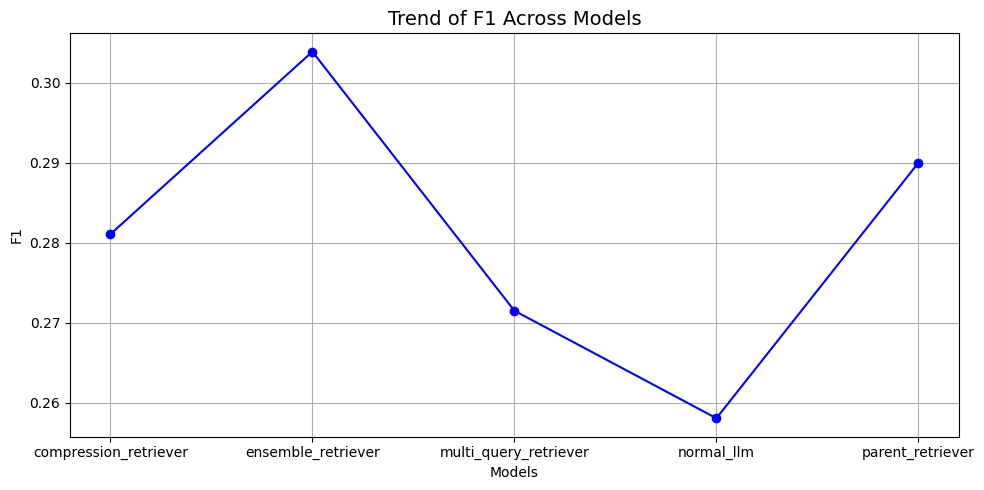

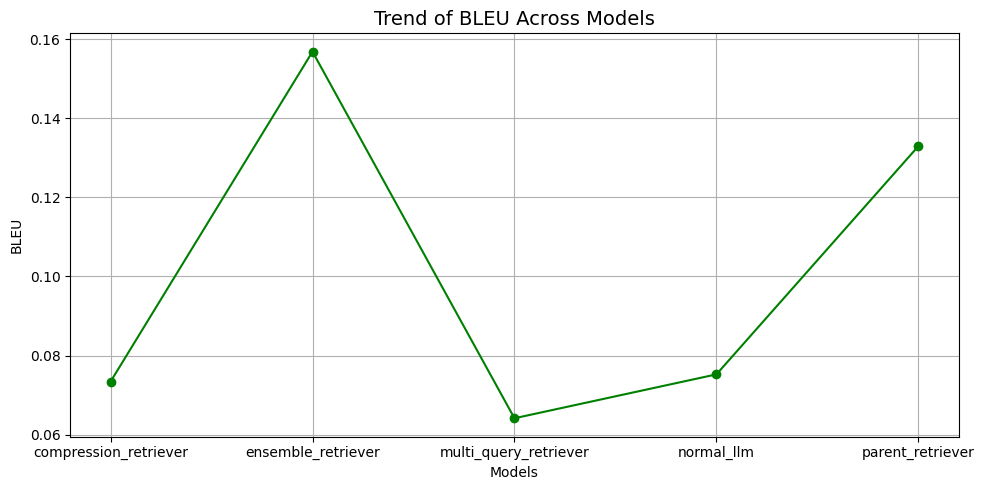

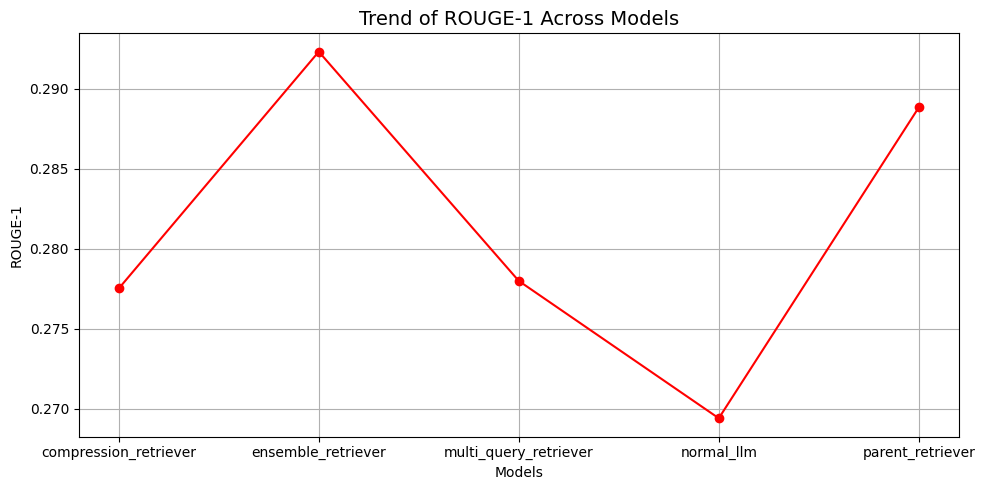

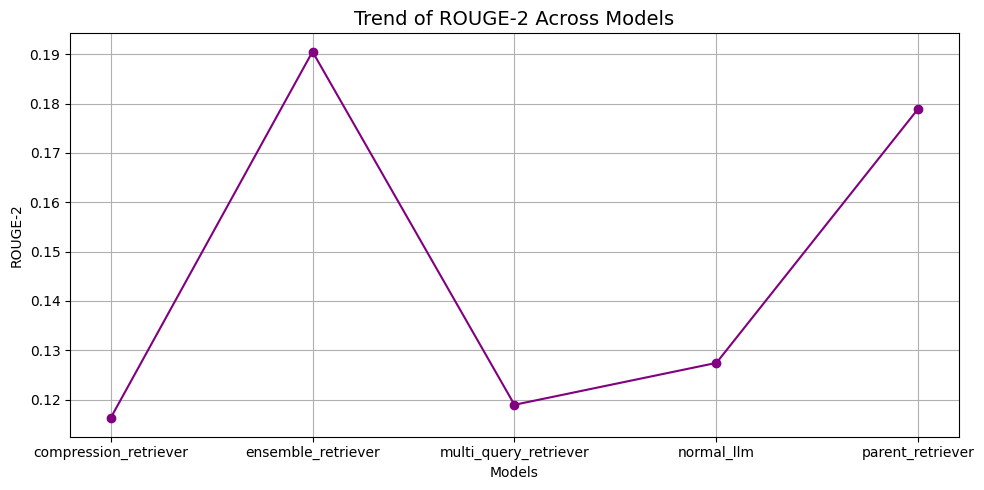

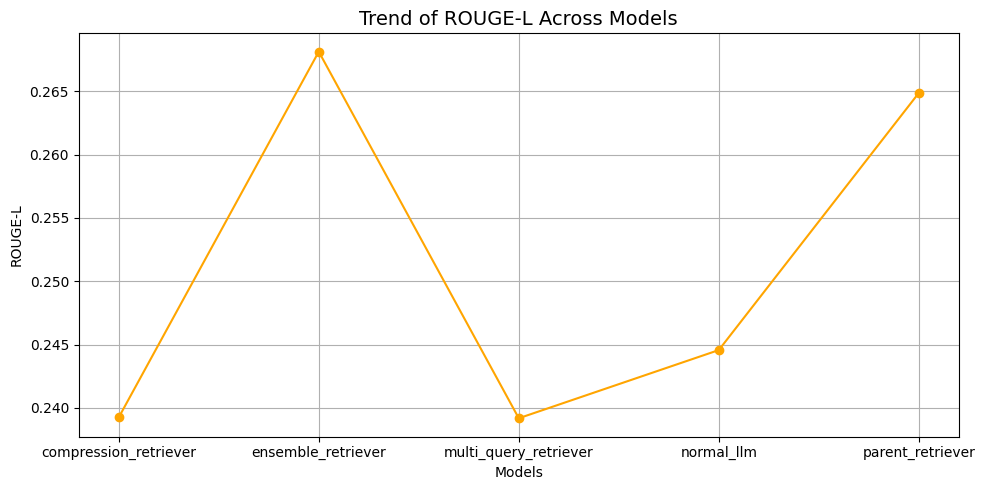

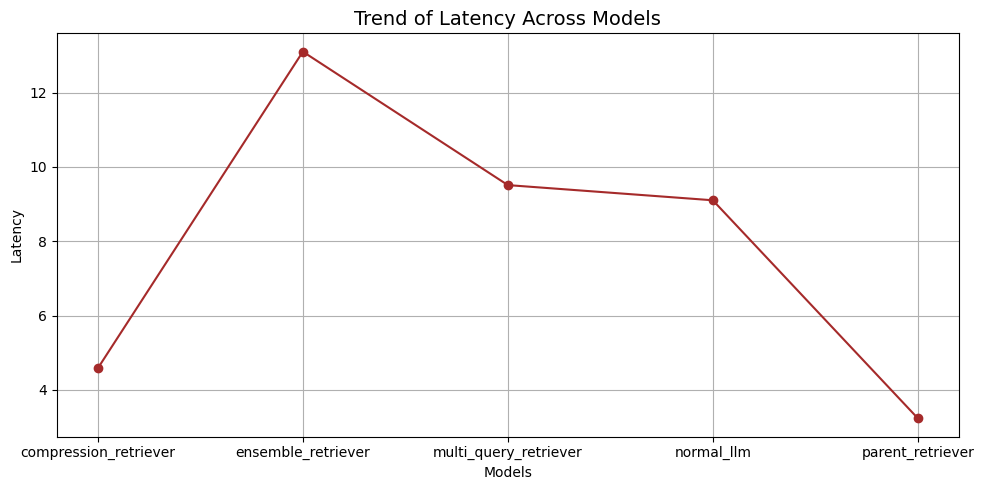

In [36]:
# Grouping data by model and calculating means for each metric
mean_metrics = df.groupby('Model').mean()

# Plotting each metric in a separate line plot
metrics = ['F1', 'BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Latency']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'gray']

for i, metric in enumerate(metrics):
    plt.figure(figsize=(10, 5))  # Size can be adjusted as needed
    plt.plot(mean_metrics.index, mean_metrics[metric], marker='o', linestyle='-', color=colors[i % len(colors)])
    plt.title(f'Trend of {metric} Across Models', fontsize=14)
    plt.ylabel(metric)
    plt.xlabel('Models')
    plt.grid(True)
    plt.xticks(mean_metrics.index)  # Ensure that model names are used as x-ticks
    plt.tight_layout()
    plt.show()